In [58]:
#!pip install natsort

In [51]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from natsort import natsorted
from pathlib import Path

In [52]:
%cd TennisCourtDetector

[Errno 2] No such file or directory: 'TennisCourtDetector'
/home/ubuntu/test-storage/TennisCourtDetector


In [54]:
#!pip install natsort

In [55]:
#!git clone https://github.com/yastrebksv/TennisCourtDetector.git
#%cd TennisCourtDetector/

In [56]:
def plot_frame(img_src, court_pts=None, net_pts=None, frame_kp=True, size=(4,4), ax=None, alpha=0.8):
  if not ax: _, ax = plt.subplots(figsize=size)
  if  type(img_src).__name__ in ('str','PosixPath'):
    if frame_kp:
      court_dict, net_dict, _ = gen_kp_dicts(clip=img_src.parent)
      court_pts, net_pts = court_dict.get(img_src.name), net_dict.get(img_src.name)
    img_src = plt.imread(img_src)
  if type(img_src).__name__=='ndarray': plt.imshow(img_src, axes=ax, alpha=alpha)
  if court_pts is not None: plt.scatter(court_pts[:,0], court_pts[:,1], c='r', s=4, axes=ax)
  if net_pts is not None: plt.scatter(net_pts[:,0], net_pts[:,1], c='b', s=4, axes=ax)
  return ax

In [9]:
def get_sorted_files(path, prefix="img_"):
    files = []
    for file_name in os.listdir(path):
        if file_name.startswith(prefix) and file_name[-4:] in [".jpg", ".png"]:
            files.append(os.path.join(path, file_name))
    return natsorted(files)

In [10]:
path = Path(f'/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/')
sorted_files = get_sorted_files(path)
len(sorted_files)

107893

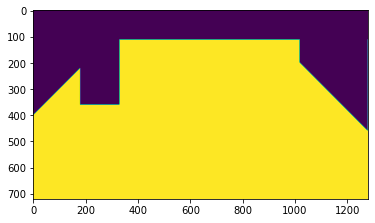

In [59]:
mask = np.ones((720,1280),dtype='uint8')
mask[100:360,180:330] = 0
mask[:112,:] = 0
#mask[690:,:] = 0
for idx in range(400):
    mask[idx,range(400-idx)] = 0
for idx in range(260):
    mask[range(200+idx), 1279-260+idx] = 0
plt.imshow(mask)

<AxesSubplot:>

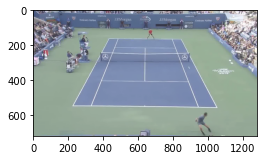

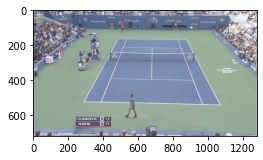

In [60]:
ref_img_f, test_img_f = path/'img_0900.jpg', path/'img_3260.jpg'
plot_frame(ref_img_f, frame_kp=False)
plot_frame(test_img_f, frame_kp=False)

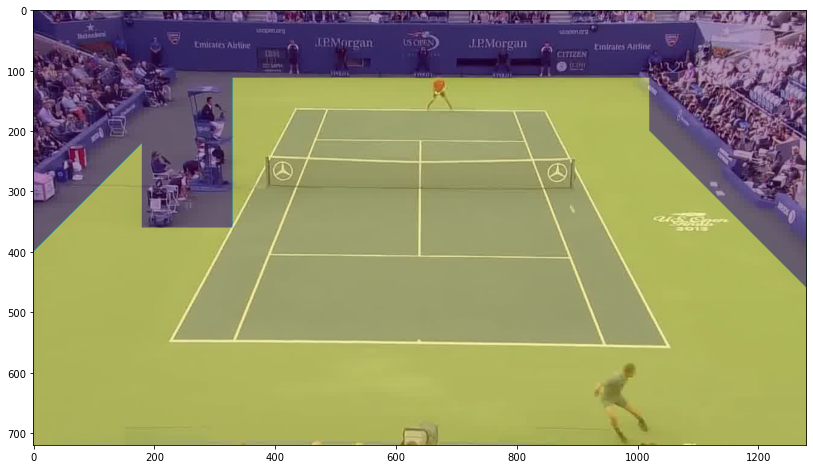

In [61]:
fig, ax = plt.subplots(1,1, figsize=(14,8))
ax.imshow(plt.imread(ref_img_f))
ax.imshow(mask, alpha=0.4)  

In [62]:
model_path='/home/ubuntu/test-storage/TennisCourtDetector/model_tennis_court_det.pt'
output_path=Path('/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0_out/')

In [63]:
!ls {model_path} {output_path} {ref_img_f} {test_img_f}

/home/ubuntu/test-storage/TennisCourtDetector/model_tennis_court_det.pt
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0900.jpg
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_3260.jpg

/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0_out:
img_0900.jpg		  test_list16_results.json  test_list3_results.json
test_list0_results.json   test_list17_results.json  test_list3_results_bk.json
test_list10_results.json  test_list18_results.json  test_list4_results.json
test_list11_results.json  test_list19_results.json  test_list5_results.json
test_list12_results.json  test_list1_results.json   test_list6_results.json
test_list13_results.json  test_list20_results.json  test_list7_results.json
test_list14_results.json  test_list21_results.json  test_list8_results.json
test_list15_results.json  test_list2_results.json


In [16]:
!ls {str(output_path/ref_img_f.name)}

/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0_out/img_0900.jpg


In [18]:
!python infer_in_image.py --input_path {str(ref_img_f)} --model_path $model_path --output_path {str(output_path/ref_img_f.name)} --use_refine_kps --use_homography

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [17]:

def add_size_to_kp(kp, size=10):
  return [cv2.KeyPoint(x, y, size) for x, y in kp.squeeze()]

def r2_dist(a,b):
  return np.sqrt(np.sum((a-b)**2))

def valid_kp(kp, img_size=(720,1280)):
  cond1 = np.all(kp[:, 0] < img_size[1]) and np.all(kp[:, 1] < img_size[0])
  cond2 = sum([r2_dist(kp[i,:], kp[j,:]) for i,j in ((0,1), (0,2), (1,3), (2,3))])
  cond3 = min([r2_dist(kp[i,:], kp[j,:]) for i,j in ((0,1), (0,2), (1,3), (2,3))])
  cond4 = r2_dist(kp[12:14,:].mean(axis=0), np.array([[640,360]]))
  #print(f'cond1: {cond1} cond2: {cond2} cond3: {cond3} cond4: {cond4}')
  return (cond1) & (cond2>1600) & (cond3>300) & (cond4<110)


def court_kp_and_validity(args):
  f1, f2, img1_kp, plot_imgs = args
  img1, img2 = cv2.imread(str(f1)), cv2.imread(str(f2))
  img1[600:700, 200:400] = np.zeros((100, 200, 3), dtype=np.uint8)
  sift = cv2.SIFT_create()
  kp1, d1 = sift.detectAndCompute(img1, None)
  kp2, d2 = sift.detectAndCompute(img2, None)
  bf = cv2.BFMatcher()
  matches = bf.knnMatch(d1, d2, k=2)
  good_matches = []
  for m, n in matches:
      if m.distance < 0.75 * n.distance:
          good_matches.append(m)
  pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
  pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
  img1_kp = np.loadtxt(img1_kp, delimiter=',')
  transformation_matrix, _ = cv2.findHomography(pts1, pts2, cv2.RANSAC, 5.0)
  try:
      img2_kp = cv2.perspectiveTransform(img1_kp.reshape(-1,1,2), transformation_matrix)
      #warped_mask = cv2.warpPerspective(mask, transformation_matrix, (mask.shape[1], mask.shape[0]))
  except:
      return f2, [[[0,0,0]]], False, [[0,0]]
  if plot_imgs:
    img1_w_kp = cv2.drawKeypoints(img1, add_size_to_kp(img1_kp), outImage=np.array([]), color=(0, 0, 255), flags=0)
    img2_w_kp = cv2.drawKeypoints(img2, add_size_to_kp(img2_kp), outImage=np.array([]), color=(0, 0, 255), flags=0)
    _, axes = plt.subplots(2,1, figsize=(20,20))
    axes[0].imshow(img1_w_kp)
    axes[1].imshow(img2_w_kp)
  return f2, img2_kp.tolist(), valid_kp(img2_kp.squeeze()), transformation_matrix.tolist()


In [18]:
mod_kp = np.zeros((18,2))
mod_kp[0] = np.array([435,164]) 
mod_kp[1] = np.array([847,167]) 
mod_kp[2] = np.array([228,548]) 
mod_kp[3] = np.array([1051,557])
mod_kp[4] = np.array([487,164])
mod_kp[5] = np.array([333,548])
mod_kp[6] = np.array([795,167])
mod_kp[7] = np.array([946,555])
mod_kp[8] = np.array([467,215])
mod_kp[9] = np.array([815,218])
mod_kp[10] = np.array([390,405])
mod_kp[11] = np.array([889,410])
mod_kp[12] = np.array([641,217])
mod_kp[13] = np.array([639,407])

mod_kp[14] = np.array([387,288])
mod_kp[15] = np.array([387,242])
mod_kp[16] = np.array([891,296])
mod_kp[17] = np.array([893,246])


np.savetxt('court_kp_v2.txt', mod_kp, delimiter=',')

In [19]:
args = ref_img_f, path/'img_0760.jpg', 'court_kp_v2.txt', False
a1,a2,a3,a4 = court_kp_and_validity(args)

In [20]:
a4

[[0.8534374219857574, -0.003254394163594513, 88.62315880001671],
 [-0.0014834748693170155, 0.8577455114577015, 50.12084656538874],
 [-4.1313549370857785e-06, -4.25122264880955e-06, 1.0]]

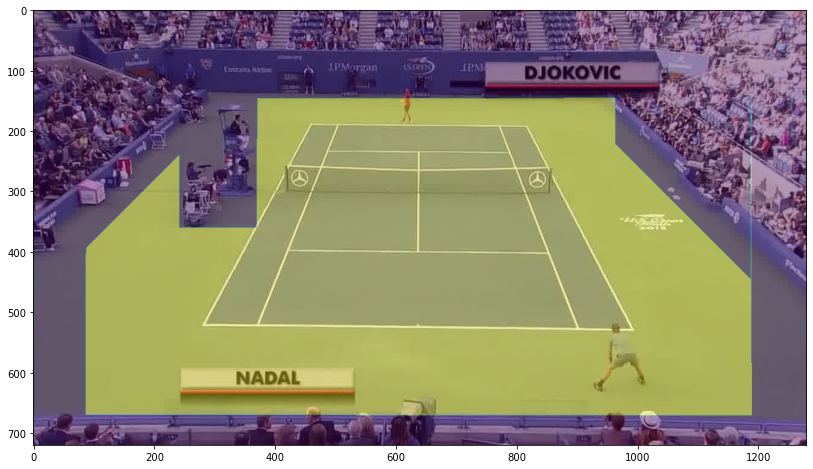

In [21]:
fig, ax = plt.subplots(1,1, figsize=(14,8))
ax.imshow(plt.imread(str(a1)))
img_mask = cv2.warpPerspective(mask, np.array(a4), (mask.shape[1], mask.shape[0]))
ax.imshow(img_mask, alpha=0.4) 

(PosixPath('/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_1200.jpg'),
 [[[374.30412455108086, 661.0637331577441]],
  [[375.30179022635923, 660.8240566310928]],
  [[373.4306038607072, 661.2346003520187]],
  [[373.96689136264774, 661.1079781189576]],
  [[374.44838075904005, 661.0292422141364]],
  [[373.50341126116734, 661.2174338318024]],
  [[375.1837659522092, 660.85226162054]],
  [[373.903219728319, 661.123028457345]],
  [[374.0724321263414, 661.1040784252626]],
  [[374.69276979861075, 660.95607414405]],
  [[373.6169431918382, 661.1948361764518]],
  [[374.064975557947, 661.088837991849]],
  [[374.39172481271254, 661.0278030227407]],
  [[373.8473349088882, 661.1403487789879]],
  [[373.7409038461092, 661.1728010947653]],
  [[373.83379191702807, 661.1561667609576]],
  [[374.379282192098, 661.0209507808325]],
  [[374.62743097951056, 660.9673179006124]]],
 False,
 [[-0.17776058980150652, -5.776416926776061, 374.0337098898051],
  [-0.304142524585

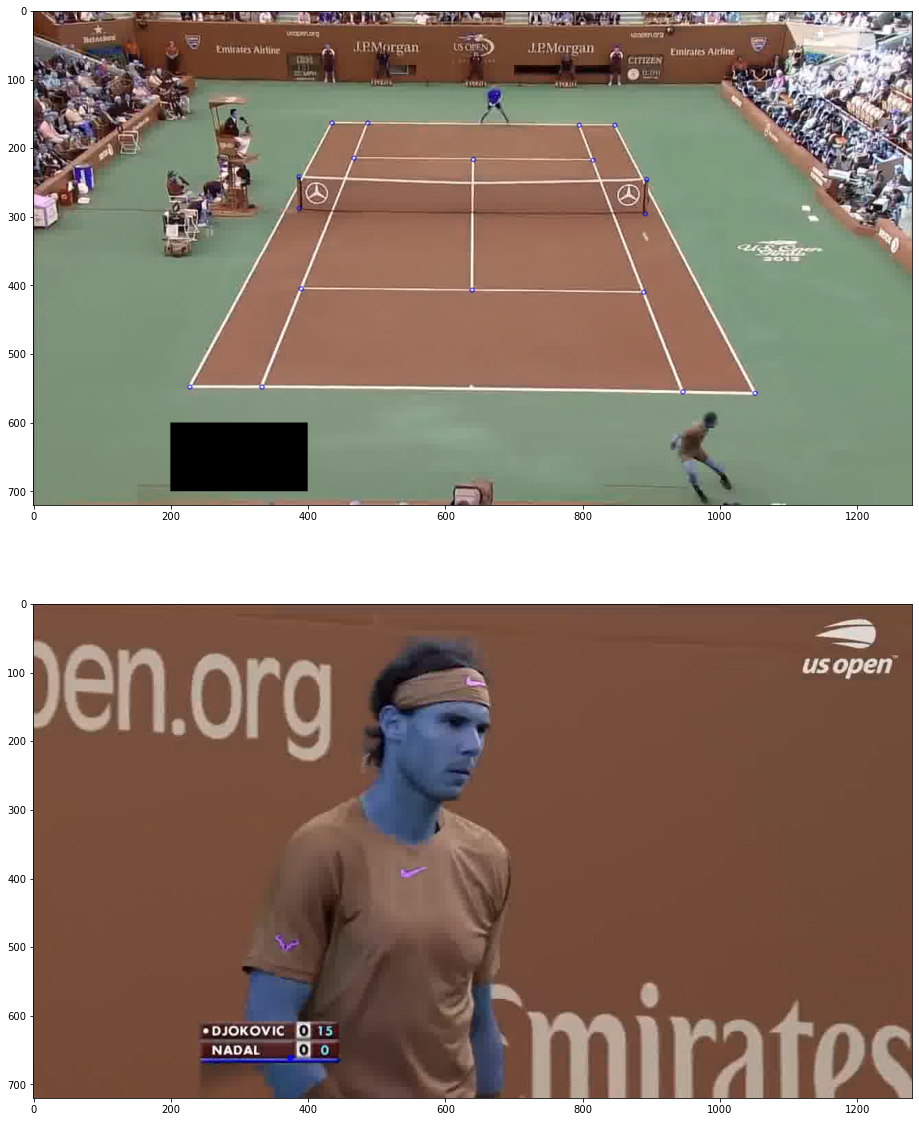

In [22]:
args = ref_img_f, path/'img_105842.jpg', 'court_kp_v2.txt', True
args = ref_img_f, path/'img_102647.jpg', 'court_kp_v2.txt', True
args = ref_img_f, path/'img_1200.jpg', 'court_kp_v2.txt', True
court_kp_and_validity(args)

In [23]:
args = ref_img_f, path/'img_3260.jpg', 'court_kp.txt', False
court_kp_and_validity(args)[-2]

True

In [24]:
args = ref_img_f, path/'img_3260.jpg', 'court_kp.txt', False
assert court_kp_and_validity(args)[-2]==True

args = ref_img_f, path/'img_1259.jpg', 'court_kp.txt', False
assert court_kp_and_validity(args)[-2]==False

args = ref_img_f, path/'img_3815.jpg', 'court_kp.txt', False
assert court_kp_and_validity(args)[-2]==False


In [25]:
# import cv2.cuda as cuda

# def cuda_court_kp_and_validity(args):
#     f1, f2, img1_kp, plot_imgs = args
#     img1 = cv2.imread(str(f1))
#     img2 = cv2.imread(str(f2))
#     img1_gpu = cuda.GpuMat(img1)
#     img2_gpu = cuda.GpuMat(img2)
#     img1_gpu[600:700, 200:400] = cuda.GpuMat(np.zeros((100, 200, 3), dtype=np.uint8))
#     sift = cuda.SIFT_create()
#     kp1_gpu, d1_gpu = sift.detectAndCompute(img1_gpu, None)
#     kp2_gpu, d2_gpu = sift.detectAndCompute(img2_gpu, None)
#     bf = cuda.BFMatcher()
#     matches = bf.knnMatch(d1_gpu, d2_gpu, k=2)
#     good_matches = []
#     for m, n in matches:
#         if m.distance < 0.75 * n.distance:
#             good_matches.append(m)

#     kp1 = kp1_gpu.downloadKeyPoints()
#     kp2 = kp2_gpu.downloadKeyPoints()
#     pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
#     pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
#     img1_kp = np.loadtxt(img1_kp, delimiter=',')

#     transformation_matrix, _ = cv2.findHomography(pts1, pts2, cv2.RANSAC, 5.0)
#     img2_kp = cv2.perspectiveTransform(img1_kp.reshape(-1, 1, 2), transformation_matrix)
#     return f2, img2_kp, valid_kp(img2_kp.squeeze())

In [26]:
import os
num_cores = os.cpu_count()
num_cores

30

In [27]:
# import time
# part_size = 1000
# part=1
# results = []

# func_time = time.time()
# for idx,f2 in enumerate(sorted_files[part*part_size:(part+4)*part_size]):    
#     args = (ref_img_f, f2, 'court_kp.txt', False)
#     out = court_kp_and_validity(args)
#     results.append(out)
#     if (idx+1)%50==0:
#         start_time = func_time
#         func_time = time.time()
#         print(f'idx: {idx+1} time: {func_time - start_time: 0.6f}')

In [28]:
# start_time = time.time()
# results_df = pd.DataFrame(results, columns=['f','kp','valid','hm'])
# results_df.to_csv(f'tmp.csv')
# tmp_df = pd.read_csv('tmp.csv', index_col=0)
# #tmp_df['kp'] = tmp_df['kp'].apply(lambda x: np.array(eval(x[1:-1])))
# #tmp_df['hm'] = tmp_df['hm'].apply(lambda x: np.array(eval(x[1:-1])))
# end_time = time.time()
# print(f'time: {end_time - start_time: 0.6f}')

In [29]:
!ls part*22*csv

part0_22_processed.csv	 part17_22_processed.csv  part4_22_processed.csv
part10_22_processed.csv  part18_22_processed.csv  part5_22_processed.csv
part11_22_processed.csv  part19_22_processed.csv  part6_22_processed.csv
part12_22_processed.csv  part1_22_processed.csv   part7_22_processed.csv
part13_22_processed.csv  part20_22_processed.csv  part8_22_processed.csv
part14_22_processed.csv  part21_22_processed.csv  part9_22_processed.csv
part15_22_processed.csv  part2_22_processed.csv
part16_22_processed.csv  part3_22_processed.csv


In [30]:
import time
import multiprocessing
part_size = 5000
n_parts = len(sorted_files)//part_size+1
for part in range(14,n_parts):
    start_time = time.time()
    pool = multiprocessing.Pool(processes=num_cores)
    results = pool.map(court_kp_and_validity, [(ref_img_f, f2, 'court_kp.txt', False) for f2 in sorted_files[part*part_size:(part+1)*part_size]])
    pool.close()
    pool.join()
    pool_end_time = time.time()
    print(f'Part: {part} Pool Time: {pool_end_time - start_time: 0.6f}')
    results_df = pd.DataFrame(results, columns=['f','kp','valid','hm'])
    results_df.to_csv(f'part{part}_{n_parts}_processed.csv')
    write_end_time = time.time()
    print(f'Part: {part} Total Time: {write_end_time - start_time: 0.6f}')

Part: 14 Pool Time:  419.342304
Part: 14 Total Time:  419.608018
Part: 15 Pool Time:  322.089010
Part: 15 Total Time:  322.343590
Part: 16 Pool Time:  311.154858
Part: 16 Total Time:  311.413457
Part: 17 Pool Time:  260.413848
Part: 17 Total Time:  260.666847
Part: 18 Pool Time:  378.857462
Part: 18 Total Time:  379.115755
Part: 19 Pool Time:  375.006843
Part: 19 Total Time:  375.264922
Part: 20 Pool Time:  415.453115
Part: 20 Total Time:  415.711184
Part: 21 Pool Time:  247.148115
Part: 21 Total Time:  247.310650


In [31]:
all_results_df = pd.DataFrame()
for part in range(n_parts):
    processed_f = f'part{part}_{n_parts}_processed.csv'
    results_df = pd.read_csv(processed_f, index_col=1)
    results_df['kp'] = results_df['kp'].apply(lambda x: np.array(eval(x[1:-1])))
    results_df['hm'] = results_df['hm'].apply(lambda x: np.array(eval(x[1:-1])))
    all_results_df = pd.concat([all_results_df, results_df], ignore_index=False)
    print(f'processed part{part} w/ range {Path(results_df.index.values[0]).name}:{Path(results_df.index.values[-1]).name} and results shape: {all_results_df.shape}')

processed part0 w/ range img_0001.jpg:img_5000.jpg and results shape: (5000, 4)
processed part1 w/ range img_5001.jpg:img_10000.jpg and results shape: (10000, 4)
processed part2 w/ range img_10001.jpg:img_15000.jpg and results shape: (15000, 4)
processed part3 w/ range img_15001.jpg:img_20000.jpg and results shape: (20000, 4)
processed part4 w/ range img_20001.jpg:img_25000.jpg and results shape: (25000, 4)
processed part5 w/ range img_25001.jpg:img_30000.jpg and results shape: (30000, 4)
processed part6 w/ range img_30001.jpg:img_35000.jpg and results shape: (35000, 4)
processed part7 w/ range img_35001.jpg:img_40000.jpg and results shape: (40000, 4)
processed part8 w/ range img_40001.jpg:img_45000.jpg and results shape: (45000, 4)
processed part9 w/ range img_45001.jpg:img_50000.jpg and results shape: (50000, 4)
processed part10 w/ range img_50001.jpg:img_55000.jpg and results shape: (55000, 4)
processed part11 w/ range img_55001.jpg:img_60000.jpg and results shape: (60000, 4)
proces

In [32]:
idx_to_drop = all_results_df[all_results_df.index.str.find('_s')!=-1].index.values
print(all_results_df.shape, len(idx_to_drop))
all_results_df = all_results_df.drop(idx_to_drop)
all_results_df['kp'] = all_results_df['kp'].apply(lambda x: x.tolist())
all_results_df['hm'] = all_results_df['hm'].apply(lambda x: x.tolist())
print(all_results_df.shape)

(107893, 4) 0
(107893, 4)


In [34]:
all_results_df.to_csv(f'allparts_{n_parts}_processed.csv')
processed_f = f'allparts_{n_parts}_processed.csv'
all_results_df = pd.read_csv(processed_f, index_col=0)
all_results_df['kp'] = all_results_df['kp'].apply(lambda x: np.array(eval(x[1:-1])))
all_results_df['hm'] = all_results_df['hm'].apply(lambda x: np.array(eval(x[1:-1])))
all_results_df.head(2)

kp  \
f                                                                                                       
/home/ubuntu/test-storage/Users/sanjaykarinje/D...  [[[1016.1526949732885, 75.69890174843563]], [[...   
/home/ubuntu/test-storage/Users/sanjaykarinje/D...  [[[775.4715749938945, 130.30700847540515]], [[...   

                                                    valid  \
f                                                           
/home/ubuntu/test-storage/Users/sanjaykarinje/D...  False   
/home/ubuntu/test-storage/Users/sanjaykarinje/D...  False   

                                                                                                   hm  
f                                                                                                      
/home/ubuntu/test-storage/Users/sanjaykarinje/D...  [[-0.821599095931071, -0.26647437589580547, 10...  
/home/ubuntu/test-storage/Users/sanjaykarinje/D...  [[-1.580038114962048, -3.2022745575799942, 795...

In [35]:
all_results_df.shape

(107893, 3)

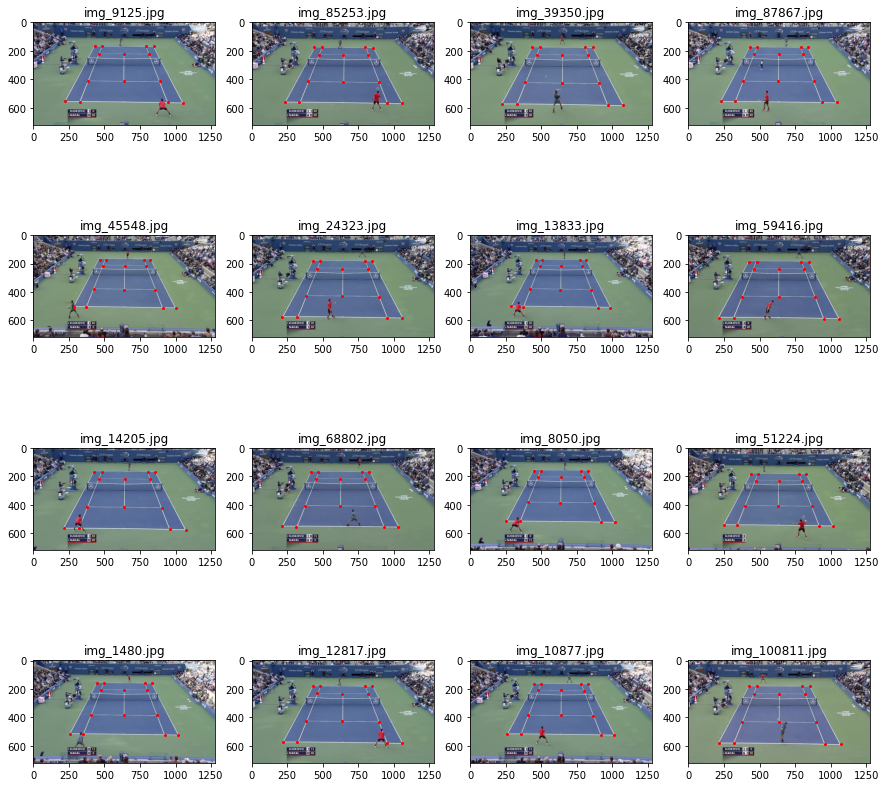

In [39]:
valid_fs, invalid_fs = all_results_df[all_results_df.valid==True].index.values, all_results_df[all_results_df.valid==False].index.values
s_valid_fs, s_invalid_fs = np.random.choice(valid_fs, size=16, replace=False), np.random.choice(invalid_fs, size=16, replace=False)
fig, axes = plt.subplots(4,4, figsize=(15,15))
axes = axes.flatten()
for ax, f in zip(axes, s_valid_fs):
  ax.imshow(cv2.imread(str(f))[:,:,::-1])
  ax.title.set_text(f.split('/')[-1])
  ax.scatter(all_results_df.loc[f].kp.squeeze()[:,0], all_results_df.loc[f].kp.squeeze()[:,1], c='r', s=4)

In [40]:
pd.set_option('display.max_rows', None)
prev_valid, all_clips, clip_num = None, [], 0
for idx, row in all_results_df.iterrows():
    if row.valid==True:
        row['clip_num'] = clip_num
        all_clips.append(row)
        prev_valid = True
    else:
        if prev_valid==True: clip_num += 1
        prev_valid=False
    

In [41]:
all_clips_df = pd.DataFrame(all_clips)
all_clips_df.head(2)

kp  \
/home/ubuntu/test-storage/Users/sanjaykarinje/D...  [[[482.36813704332025, 195.91872988708386]], [...   
/home/ubuntu/test-storage/Users/sanjaykarinje/D...  [[[481.82247925884775, 196.25295148511407]], [...   

                                                    valid  \
/home/ubuntu/test-storage/Users/sanjaykarinje/D...   True   
/home/ubuntu/test-storage/Users/sanjaykarinje/D...   True   

                                                                                                   hm  \
/home/ubuntu/test-storage/Users/sanjaykarinje/D...  [[0.7503857249668618, -0.0023650286235911543, ...   
/home/ubuntu/test-storage/Users/sanjaykarinje/D...  [[0.7455061734527989, -0.013952439968895928, 1...   

                                                    clip_num  
/home/ubuntu/test-storage/Users/sanjaykarinje/D...         0  
/home/ubuntu/test-storage/Users/sanjaykarinje/D...         0

In [42]:
pd.options.display.max_colwidth = 200
all_clips_grp = all_clips_df.reset_index().groupby('clip_num').apply(lambda x: pd.Series([x['kp'].count()]))
all_clips_grp.columns =['f_count']
all_clips_grp['first_f'] = all_clips_df.reset_index().groupby('clip_num').first()['index'].values
all_clips_grp['last_f'] = all_clips_df.reset_index().groupby('clip_num').last()['index'].values

In [43]:
all_clips_df.head(2)

kp  \
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0710.jpg  [[[482.36813704332025, 195.91872988708386]], [[792.9427859244189, 196.7300572061688]], [[325.1729984328427, 487.9555067441538]], [[948.745699089998, 495.97337740014393]], [[520.9315425456771, 196....   
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0711.jpg  [[[481.82247925884775, 196.25295148511407]], [[792.9945918370564, 197.0142347458942]], [[322.6802487523602, 488.27437208953864]], [[952.4077201859822, 497.1341740216456]], [[520.4109324598452, 196...   

                                                                                                      valid  \
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0710.jpg   True   
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0711.jpg   True   

                                                                                                                                                                                                                                                                                                           hm  \
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0710.jpg  [[0.7503857249668618, -0.0023650286235911543, 155.89179257267347], [-0.0007187596952014431, 0.7575267167208082, 72.26868300543076], [-4.28486997642961e-06, -3.782610028059799e-06, 0.99999999999999...   
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0711.jpg                [[0.7455061734527989, -0.013952439968895928, 157.06430684915867], [-0.0015043898152358058, 0.7445806764117725, 74.12063795414491], [-7.716353528719578e-06, -2.379980463817565e-05, 1.0]]   

                                                                                                      clip_num  
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0710.jpg         0  
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0711.jpg         0

In [44]:
all_clips_grp.head(2)

f_count  \
clip_num            
0             468   
1             621   

                                                                                                       first_f  \
clip_num                                                                                                         
0         /home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0710.jpg   
1         /home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_1313.jpg   

                                                                                                        last_f  
clip_num                                                                                                        
0         /home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_1177.jpg  
1         /home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_1933.jpg

In [45]:
#valid clips
all_clips_grp[all_clips_grp.f_count>100].shape

(96, 3)

In [46]:
f'{path.stem}_processed.csv'

'usopen_2013_1_processed.csv'

In [47]:
all_clips_df['kp'] = all_clips_df['kp'].apply(lambda x: x.tolist())
all_clips_df['hm'] = all_clips_df['hm'].apply(lambda x: x.tolist())
all_clips_df[all_clips_df.clip_num.isin(all_clips_grp[all_clips_grp.f_count>100].index.values)].to_csv(f'{path.stem}_processed.csv')
all_clips_df = pd.read_csv(f'{path.stem}_processed.csv', index_col=0)
all_clips_df['kp'] = all_clips_df['kp'].apply(lambda x: np.array(eval(x[1:-1])))
all_clips_df['hm'] = all_clips_df['hm'].apply(lambda x: np.array(eval(x[1:-1])))
all_clips_df.head(3)

kp  \
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0710.jpg  [[[482.36813704332025, 195.91872988708386]], [[792.9427859244189, 196.7300572061688]], [[325.1729984328427, 487.9555067441538]], [[948.745699089998, 495.97337740014393]], [[520.9315425456771, 196....   
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0711.jpg  [[[481.82247925884775, 196.25295148511407]], [[792.9945918370564, 197.0142347458942]], [[322.6802487523602, 488.27437208953864]], [[952.4077201859822, 497.1341740216456]], [[520.4109324598452, 196...   
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0712.jpg  [[[481.45857129283525, 195.63769328519024]], [[794.1457531633523, 196.18501154048613]], [[323.3385195681716, 488.68129551652527]], [[951.0398414174518, 497.51389824467174]], [[520.2095209015334, 1...   

                                                                                                      valid  \
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0710.jpg   True   
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0711.jpg   True   
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0712.jpg   True   

                                                                                                                                                                                                                                                                                                           hm  \
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0710.jpg  [[0.7503857249668618, -0.0023650286235911543, 155.89179257267347], [-0.0007187596952014431, 0.7575267167208082, 72.26868300543076], [-4.28486997642961e-06, -3.782610028059799e-06, 0.99999999999999...   
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0711.jpg                [[0.7455061734527989, -0.013952439968895928, 157.06430684915867], [-0.0015043898152358058, 0.7445806764117725, 74.12063795414491], [-7.716353528719578e-06, -2.379980463817565e-05, 1.0]]   
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0712.jpg    [[0.749597192153441, -0.003209856181675795, 154.38816305138857], [-0.00240458604853427, 0.7591268253497039, 72.02184730572256], [-9.589686610671162e-06, -3.372158816828364e-06, 0.9999999999999999]]   

                                                                                                      clip_num  
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0710.jpg         0  
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0711.jpg         0  
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0712.jpg         0

In [48]:
#all_clips_df[all_clips_df.clip_num==0]

In [49]:
#valid_frames
len(all_clips_df[all_clips_df.clip_num.isin(all_clips_grp[all_clips_grp.f_count>100].index.values)].index.values),\
all_clips_df.shape


(54395, (54395, 4))

In [25]:
# !mkdir -p {str(path.parent/(path.stem+'_valid'))}
# !ls -d {str(path.parent/(path.stem+'_valid'))}
# start_time = time.time()
# for f in all_clips_df[all_clips_df.clip_num.isin(all_clips_grp[all_clips_grp.f_count>100].index.values)].index.values[:100]:
#     f = Path(f)
#     !ln -s {str(f)} {str(path.parent/(path.stem+'_valid')/(f.name))}
# end_time = time.time()
# print(f'total time: {end_time-start_time: 0.06f}')

In [26]:
!ls {str(path.parent/(path.stem+'_valid'))}

/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `ls {str(path.parent/(path.stem+'_valid'))}'


In [607]:
# valid_frames + frames in short clips
all_results_df[all_results_df.valid==True].shape 

(55878, 2)

In [30]:
wrong_imgs = all_clips_df[all_clips_df.clip_num.isin(all_clips_grp[all_clips_grp.f_count<=100].index.values)].index.values
len(wrong_imgs)

1320

In [34]:
all_valid_arr = all_clips_df[all_clips_df.clip_num.isin(all_clips_grp[all_clips_grp.f_count>100].index.values)].index.values
all_valid_arr.shape
np.savetxt('usopen_2013_1.0_valid_imgs.txt', all_valid_arr, fmt='%s')
#np.save('usopen_2013_1.0_valid_imgs.npy', all_valid_arr)

In [37]:
!cat usopen_2013_1.0_valid_imgs.txt | head -n10

/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0710.jpg
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0711.jpg
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0712.jpg
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0713.jpg
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0714.jpg
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0715.jpg
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0716.jpg
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0717.jpg
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0718.jpg
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img

In [39]:
!ls /home/ubuntu/test-storage/TennisCourtDetector/usopen_2013_1.0_valid_imgs.txt

/home/ubuntu/test-storage/TennisCourtDetector/usopen_2013_1.0_valid_imgs.txt


In [58]:
#!pip install natsort

In [51]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from natsort import natsorted
from pathlib import Path

In [52]:
%cd TennisCourtDetector

[Errno 2] No such file or directory: 'TennisCourtDetector'
/home/ubuntu/test-storage/TennisCourtDetector


In [54]:
#!pip install natsort

In [55]:
#!git clone https://github.com/yastrebksv/TennisCourtDetector.git
#%cd TennisCourtDetector/

In [56]:
def plot_frame(img_src, court_pts=None, net_pts=None, frame_kp=True, size=(4,4), ax=None, alpha=0.8):
  if not ax: _, ax = plt.subplots(figsize=size)
  if  type(img_src).__name__ in ('str','PosixPath'):
    if frame_kp:
      court_dict, net_dict, _ = gen_kp_dicts(clip=img_src.parent)
      court_pts, net_pts = court_dict.get(img_src.name), net_dict.get(img_src.name)
    img_src = plt.imread(img_src)
  if type(img_src).__name__=='ndarray': plt.imshow(img_src, axes=ax, alpha=alpha)
  if court_pts is not None: plt.scatter(court_pts[:,0], court_pts[:,1], c='r', s=4, axes=ax)
  if net_pts is not None: plt.scatter(net_pts[:,0], net_pts[:,1], c='b', s=4, axes=ax)
  return ax

In [9]:
def get_sorted_files(path, prefix="img_"):
    files = []
    for file_name in os.listdir(path):
        if file_name.startswith(prefix) and file_name[-4:] in [".jpg", ".png"]:
            files.append(os.path.join(path, file_name))
    return natsorted(files)

In [10]:
path = Path(f'/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/')
sorted_files = get_sorted_files(path)
len(sorted_files)

107893

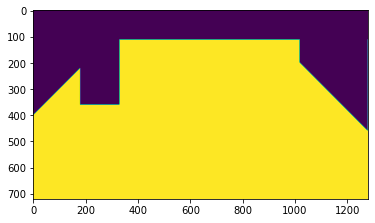

In [59]:
mask = np.ones((720,1280),dtype='uint8')
mask[100:360,180:330] = 0
mask[:112,:] = 0
#mask[690:,:] = 0
for idx in range(400):
    mask[idx,range(400-idx)] = 0
for idx in range(260):
    mask[range(200+idx), 1279-260+idx] = 0
plt.imshow(mask)

<AxesSubplot:>

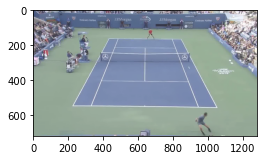

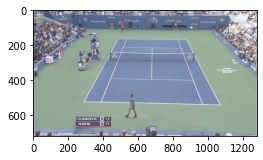

In [60]:
ref_img_f, test_img_f = path/'img_0900.jpg', path/'img_3260.jpg'
plot_frame(ref_img_f, frame_kp=False)
plot_frame(test_img_f, frame_kp=False)

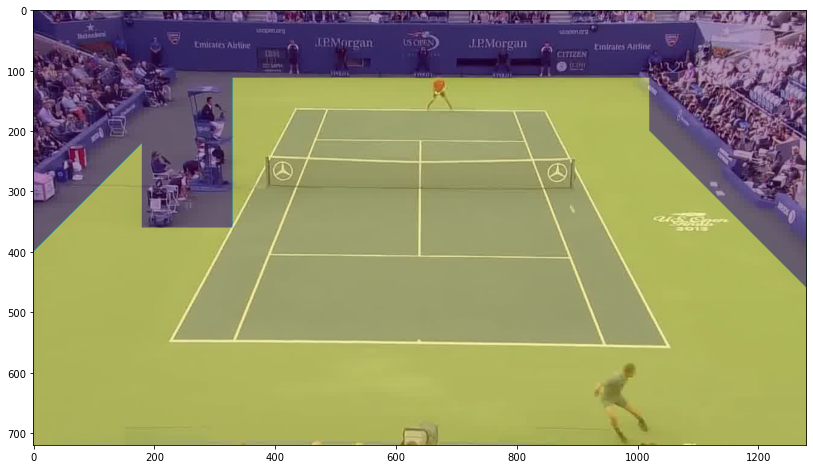

In [61]:
fig, ax = plt.subplots(1,1, figsize=(14,8))
ax.imshow(plt.imread(ref_img_f))
ax.imshow(mask, alpha=0.4)  

In [62]:
model_path='/home/ubuntu/test-storage/TennisCourtDetector/model_tennis_court_det.pt'
output_path=Path('/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0_out/')

In [63]:
!ls {model_path} {output_path} {ref_img_f} {test_img_f}

/home/ubuntu/test-storage/TennisCourtDetector/model_tennis_court_det.pt
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0900.jpg
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_3260.jpg

/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0_out:
img_0900.jpg		  test_list16_results.json  test_list3_results.json
test_list0_results.json   test_list17_results.json  test_list3_results_bk.json
test_list10_results.json  test_list18_results.json  test_list4_results.json
test_list11_results.json  test_list19_results.json  test_list5_results.json
test_list12_results.json  test_list1_results.json   test_list6_results.json
test_list13_results.json  test_list20_results.json  test_list7_results.json
test_list14_results.json  test_list21_results.json  test_list8_results.json
test_list15_results.json  test_list2_results.json


In [16]:
!ls {str(output_path/ref_img_f.name)}

/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0_out/img_0900.jpg


In [18]:
!python infer_in_image.py --input_path {str(ref_img_f)} --model_path $model_path --output_path {str(output_path/ref_img_f.name)} --use_refine_kps --use_homography

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [17]:

def add_size_to_kp(kp, size=10):
  return [cv2.KeyPoint(x, y, size) for x, y in kp.squeeze()]

def r2_dist(a,b):
  return np.sqrt(np.sum((a-b)**2))

def valid_kp(kp, img_size=(720,1280)):
  cond1 = np.all(kp[:, 0] < img_size[1]) and np.all(kp[:, 1] < img_size[0])
  cond2 = sum([r2_dist(kp[i,:], kp[j,:]) for i,j in ((0,1), (0,2), (1,3), (2,3))])
  cond3 = min([r2_dist(kp[i,:], kp[j,:]) for i,j in ((0,1), (0,2), (1,3), (2,3))])
  cond4 = r2_dist(kp[12:14,:].mean(axis=0), np.array([[640,360]]))
  #print(f'cond1: {cond1} cond2: {cond2} cond3: {cond3} cond4: {cond4}')
  return (cond1) & (cond2>1600) & (cond3>300) & (cond4<110)


def court_kp_and_validity(args):
  f1, f2, img1_kp, plot_imgs = args
  img1, img2 = cv2.imread(str(f1)), cv2.imread(str(f2))
  img1[600:700, 200:400] = np.zeros((100, 200, 3), dtype=np.uint8)
  sift = cv2.SIFT_create()
  kp1, d1 = sift.detectAndCompute(img1, None)
  kp2, d2 = sift.detectAndCompute(img2, None)
  bf = cv2.BFMatcher()
  matches = bf.knnMatch(d1, d2, k=2)
  good_matches = []
  for m, n in matches:
      if m.distance < 0.75 * n.distance:
          good_matches.append(m)
  pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
  pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
  img1_kp = np.loadtxt(img1_kp, delimiter=',')
  transformation_matrix, _ = cv2.findHomography(pts1, pts2, cv2.RANSAC, 5.0)
  try:
      img2_kp = cv2.perspectiveTransform(img1_kp.reshape(-1,1,2), transformation_matrix)
      #warped_mask = cv2.warpPerspective(mask, transformation_matrix, (mask.shape[1], mask.shape[0]))
  except:
      return f2, [[[0,0,0]]], False, [[0,0]]
  if plot_imgs:
    img1_w_kp = cv2.drawKeypoints(img1, add_size_to_kp(img1_kp), outImage=np.array([]), color=(0, 0, 255), flags=0)
    img2_w_kp = cv2.drawKeypoints(img2, add_size_to_kp(img2_kp), outImage=np.array([]), color=(0, 0, 255), flags=0)
    _, axes = plt.subplots(2,1, figsize=(20,20))
    axes[0].imshow(img1_w_kp)
    axes[1].imshow(img2_w_kp)
  return f2, img2_kp.tolist(), valid_kp(img2_kp.squeeze()), transformation_matrix.tolist()


In [18]:
mod_kp = np.zeros((18,2))
mod_kp[0] = np.array([435,164]) 
mod_kp[1] = np.array([847,167]) 
mod_kp[2] = np.array([228,548]) 
mod_kp[3] = np.array([1051,557])
mod_kp[4] = np.array([487,164])
mod_kp[5] = np.array([333,548])
mod_kp[6] = np.array([795,167])
mod_kp[7] = np.array([946,555])
mod_kp[8] = np.array([467,215])
mod_kp[9] = np.array([815,218])
mod_kp[10] = np.array([390,405])
mod_kp[11] = np.array([889,410])
mod_kp[12] = np.array([641,217])
mod_kp[13] = np.array([639,407])

mod_kp[14] = np.array([387,288])
mod_kp[15] = np.array([387,242])
mod_kp[16] = np.array([891,296])
mod_kp[17] = np.array([893,246])


np.savetxt('court_kp_v2.txt', mod_kp, delimiter=',')

In [19]:
args = ref_img_f, path/'img_0760.jpg', 'court_kp_v2.txt', False
a1,a2,a3,a4 = court_kp_and_validity(args)

In [20]:
a4

[[0.8534374219857574, -0.003254394163594513, 88.62315880001671],
 [-0.0014834748693170155, 0.8577455114577015, 50.12084656538874],
 [-4.1313549370857785e-06, -4.25122264880955e-06, 1.0]]

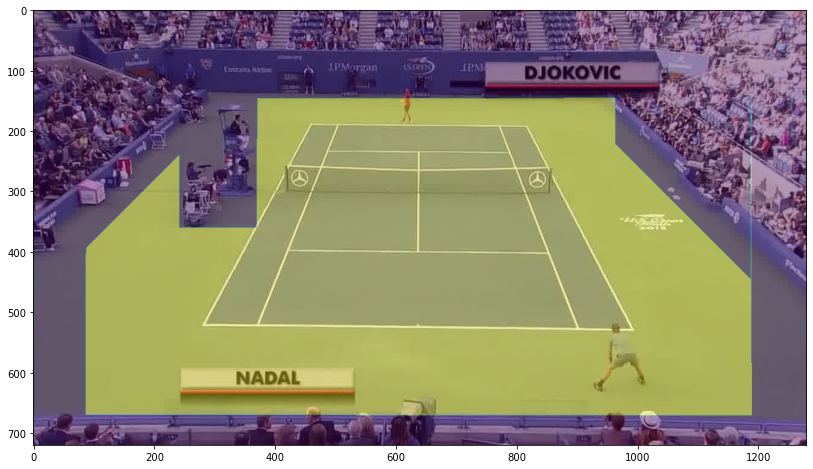

In [21]:
fig, ax = plt.subplots(1,1, figsize=(14,8))
ax.imshow(plt.imread(str(a1)))
img_mask = cv2.warpPerspective(mask, np.array(a4), (mask.shape[1], mask.shape[0]))
ax.imshow(img_mask, alpha=0.4) 

(PosixPath('/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_1200.jpg'),
 [[[374.30412455108086, 661.0637331577441]],
  [[375.30179022635923, 660.8240566310928]],
  [[373.4306038607072, 661.2346003520187]],
  [[373.96689136264774, 661.1079781189576]],
  [[374.44838075904005, 661.0292422141364]],
  [[373.50341126116734, 661.2174338318024]],
  [[375.1837659522092, 660.85226162054]],
  [[373.903219728319, 661.123028457345]],
  [[374.0724321263414, 661.1040784252626]],
  [[374.69276979861075, 660.95607414405]],
  [[373.6169431918382, 661.1948361764518]],
  [[374.064975557947, 661.088837991849]],
  [[374.39172481271254, 661.0278030227407]],
  [[373.8473349088882, 661.1403487789879]],
  [[373.7409038461092, 661.1728010947653]],
  [[373.83379191702807, 661.1561667609576]],
  [[374.379282192098, 661.0209507808325]],
  [[374.62743097951056, 660.9673179006124]]],
 False,
 [[-0.17776058980150652, -5.776416926776061, 374.0337098898051],
  [-0.304142524585

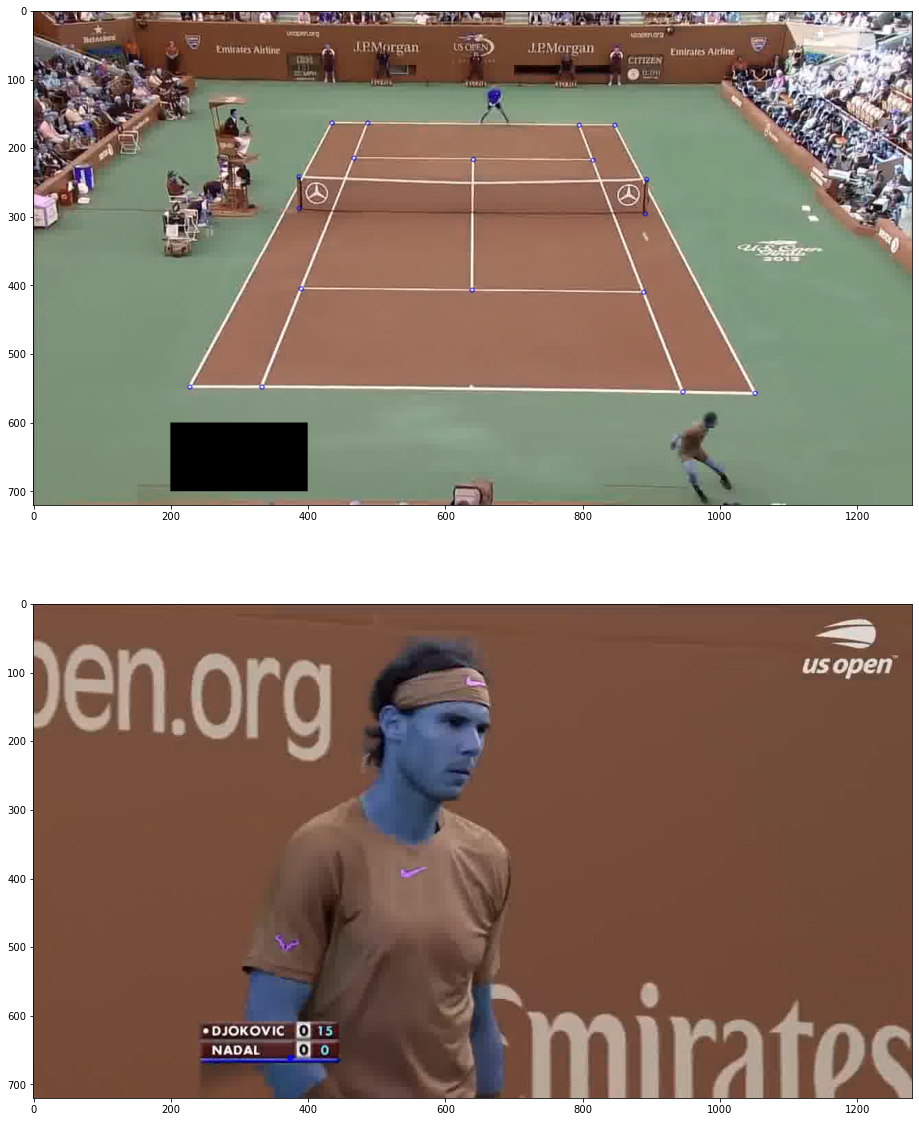

In [22]:
args = ref_img_f, path/'img_105842.jpg', 'court_kp_v2.txt', True
args = ref_img_f, path/'img_102647.jpg', 'court_kp_v2.txt', True
args = ref_img_f, path/'img_1200.jpg', 'court_kp_v2.txt', True
court_kp_and_validity(args)

In [23]:
args = ref_img_f, path/'img_3260.jpg', 'court_kp.txt', False
court_kp_and_validity(args)[-2]

True

In [24]:
args = ref_img_f, path/'img_3260.jpg', 'court_kp.txt', False
assert court_kp_and_validity(args)[-2]==True

args = ref_img_f, path/'img_1259.jpg', 'court_kp.txt', False
assert court_kp_and_validity(args)[-2]==False

args = ref_img_f, path/'img_3815.jpg', 'court_kp.txt', False
assert court_kp_and_validity(args)[-2]==False


In [25]:
# import cv2.cuda as cuda

# def cuda_court_kp_and_validity(args):
#     f1, f2, img1_kp, plot_imgs = args
#     img1 = cv2.imread(str(f1))
#     img2 = cv2.imread(str(f2))
#     img1_gpu = cuda.GpuMat(img1)
#     img2_gpu = cuda.GpuMat(img2)
#     img1_gpu[600:700, 200:400] = cuda.GpuMat(np.zeros((100, 200, 3), dtype=np.uint8))
#     sift = cuda.SIFT_create()
#     kp1_gpu, d1_gpu = sift.detectAndCompute(img1_gpu, None)
#     kp2_gpu, d2_gpu = sift.detectAndCompute(img2_gpu, None)
#     bf = cuda.BFMatcher()
#     matches = bf.knnMatch(d1_gpu, d2_gpu, k=2)
#     good_matches = []
#     for m, n in matches:
#         if m.distance < 0.75 * n.distance:
#             good_matches.append(m)

#     kp1 = kp1_gpu.downloadKeyPoints()
#     kp2 = kp2_gpu.downloadKeyPoints()
#     pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
#     pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
#     img1_kp = np.loadtxt(img1_kp, delimiter=',')

#     transformation_matrix, _ = cv2.findHomography(pts1, pts2, cv2.RANSAC, 5.0)
#     img2_kp = cv2.perspectiveTransform(img1_kp.reshape(-1, 1, 2), transformation_matrix)
#     return f2, img2_kp, valid_kp(img2_kp.squeeze())

In [26]:
import os
num_cores = os.cpu_count()
num_cores

30

In [27]:
# import time
# part_size = 1000
# part=1
# results = []

# func_time = time.time()
# for idx,f2 in enumerate(sorted_files[part*part_size:(part+4)*part_size]):    
#     args = (ref_img_f, f2, 'court_kp.txt', False)
#     out = court_kp_and_validity(args)
#     results.append(out)
#     if (idx+1)%50==0:
#         start_time = func_time
#         func_time = time.time()
#         print(f'idx: {idx+1} time: {func_time - start_time: 0.6f}')

In [28]:
# start_time = time.time()
# results_df = pd.DataFrame(results, columns=['f','kp','valid','hm'])
# results_df.to_csv(f'tmp.csv')
# tmp_df = pd.read_csv('tmp.csv', index_col=0)
# #tmp_df['kp'] = tmp_df['kp'].apply(lambda x: np.array(eval(x[1:-1])))
# #tmp_df['hm'] = tmp_df['hm'].apply(lambda x: np.array(eval(x[1:-1])))
# end_time = time.time()
# print(f'time: {end_time - start_time: 0.6f}')

In [29]:
!ls part*22*csv

part0_22_processed.csv	 part17_22_processed.csv  part4_22_processed.csv
part10_22_processed.csv  part18_22_processed.csv  part5_22_processed.csv
part11_22_processed.csv  part19_22_processed.csv  part6_22_processed.csv
part12_22_processed.csv  part1_22_processed.csv   part7_22_processed.csv
part13_22_processed.csv  part20_22_processed.csv  part8_22_processed.csv
part14_22_processed.csv  part21_22_processed.csv  part9_22_processed.csv
part15_22_processed.csv  part2_22_processed.csv
part16_22_processed.csv  part3_22_processed.csv


In [30]:
import time
import multiprocessing
part_size = 5000
n_parts = len(sorted_files)//part_size+1
for part in range(14,n_parts):
    start_time = time.time()
    pool = multiprocessing.Pool(processes=num_cores)
    results = pool.map(court_kp_and_validity, [(ref_img_f, f2, 'court_kp.txt', False) for f2 in sorted_files[part*part_size:(part+1)*part_size]])
    pool.close()
    pool.join()
    pool_end_time = time.time()
    print(f'Part: {part} Pool Time: {pool_end_time - start_time: 0.6f}')
    results_df = pd.DataFrame(results, columns=['f','kp','valid','hm'])
    results_df.to_csv(f'part{part}_{n_parts}_processed.csv')
    write_end_time = time.time()
    print(f'Part: {part} Total Time: {write_end_time - start_time: 0.6f}')

Part: 14 Pool Time:  419.342304
Part: 14 Total Time:  419.608018
Part: 15 Pool Time:  322.089010
Part: 15 Total Time:  322.343590
Part: 16 Pool Time:  311.154858
Part: 16 Total Time:  311.413457
Part: 17 Pool Time:  260.413848
Part: 17 Total Time:  260.666847
Part: 18 Pool Time:  378.857462
Part: 18 Total Time:  379.115755
Part: 19 Pool Time:  375.006843
Part: 19 Total Time:  375.264922
Part: 20 Pool Time:  415.453115
Part: 20 Total Time:  415.711184
Part: 21 Pool Time:  247.148115
Part: 21 Total Time:  247.310650


In [31]:
all_results_df = pd.DataFrame()
for part in range(n_parts):
    processed_f = f'part{part}_{n_parts}_processed.csv'
    results_df = pd.read_csv(processed_f, index_col=1)
    results_df['kp'] = results_df['kp'].apply(lambda x: np.array(eval(x[1:-1])))
    results_df['hm'] = results_df['hm'].apply(lambda x: np.array(eval(x[1:-1])))
    all_results_df = pd.concat([all_results_df, results_df], ignore_index=False)
    print(f'processed part{part} w/ range {Path(results_df.index.values[0]).name}:{Path(results_df.index.values[-1]).name} and results shape: {all_results_df.shape}')

processed part0 w/ range img_0001.jpg:img_5000.jpg and results shape: (5000, 4)
processed part1 w/ range img_5001.jpg:img_10000.jpg and results shape: (10000, 4)
processed part2 w/ range img_10001.jpg:img_15000.jpg and results shape: (15000, 4)
processed part3 w/ range img_15001.jpg:img_20000.jpg and results shape: (20000, 4)
processed part4 w/ range img_20001.jpg:img_25000.jpg and results shape: (25000, 4)
processed part5 w/ range img_25001.jpg:img_30000.jpg and results shape: (30000, 4)
processed part6 w/ range img_30001.jpg:img_35000.jpg and results shape: (35000, 4)
processed part7 w/ range img_35001.jpg:img_40000.jpg and results shape: (40000, 4)
processed part8 w/ range img_40001.jpg:img_45000.jpg and results shape: (45000, 4)
processed part9 w/ range img_45001.jpg:img_50000.jpg and results shape: (50000, 4)
processed part10 w/ range img_50001.jpg:img_55000.jpg and results shape: (55000, 4)
processed part11 w/ range img_55001.jpg:img_60000.jpg and results shape: (60000, 4)
proces

In [32]:
idx_to_drop = all_results_df[all_results_df.index.str.find('_s')!=-1].index.values
print(all_results_df.shape, len(idx_to_drop))
all_results_df = all_results_df.drop(idx_to_drop)
all_results_df['kp'] = all_results_df['kp'].apply(lambda x: x.tolist())
all_results_df['hm'] = all_results_df['hm'].apply(lambda x: x.tolist())
print(all_results_df.shape)

(107893, 4) 0
(107893, 4)


In [34]:
all_results_df.to_csv(f'allparts_{n_parts}_processed.csv')
processed_f = f'allparts_{n_parts}_processed.csv'
all_results_df = pd.read_csv(processed_f, index_col=0)
all_results_df['kp'] = all_results_df['kp'].apply(lambda x: np.array(eval(x[1:-1])))
all_results_df['hm'] = all_results_df['hm'].apply(lambda x: np.array(eval(x[1:-1])))
all_results_df.head(2)

kp  \
f                                                                                                       
/home/ubuntu/test-storage/Users/sanjaykarinje/D...  [[[1016.1526949732885, 75.69890174843563]], [[...   
/home/ubuntu/test-storage/Users/sanjaykarinje/D...  [[[775.4715749938945, 130.30700847540515]], [[...   

                                                    valid  \
f                                                           
/home/ubuntu/test-storage/Users/sanjaykarinje/D...  False   
/home/ubuntu/test-storage/Users/sanjaykarinje/D...  False   

                                                                                                   hm  
f                                                                                                      
/home/ubuntu/test-storage/Users/sanjaykarinje/D...  [[-0.821599095931071, -0.26647437589580547, 10...  
/home/ubuntu/test-storage/Users/sanjaykarinje/D...  [[-1.580038114962048, -3.2022745575799942, 795...

In [35]:
all_results_df.shape

(107893, 3)

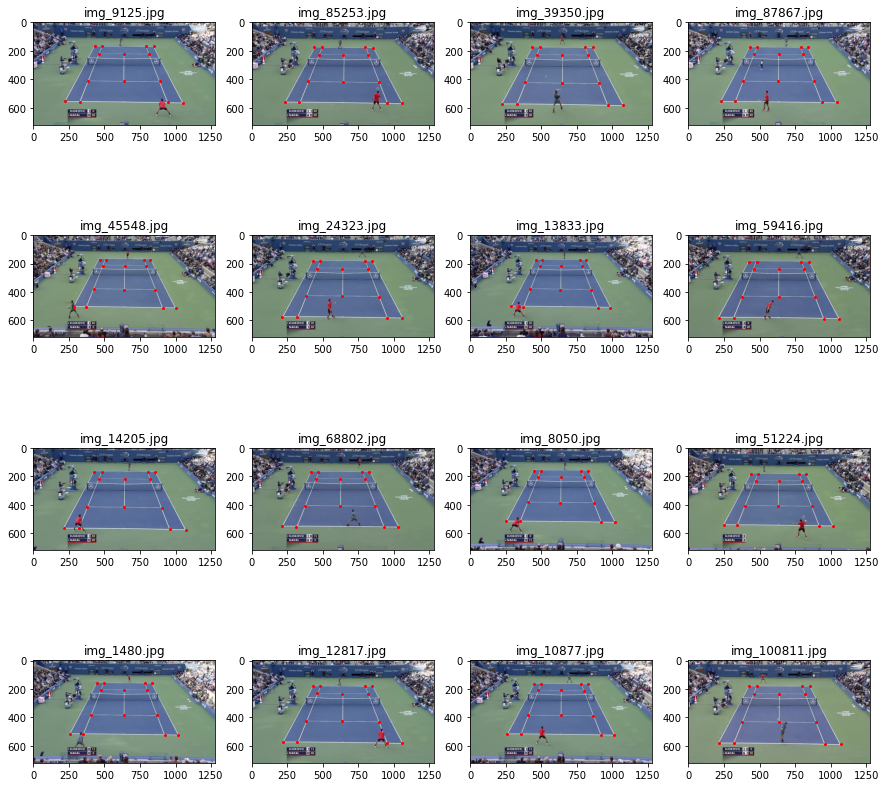

In [39]:
valid_fs, invalid_fs = all_results_df[all_results_df.valid==True].index.values, all_results_df[all_results_df.valid==False].index.values
s_valid_fs, s_invalid_fs = np.random.choice(valid_fs, size=16, replace=False), np.random.choice(invalid_fs, size=16, replace=False)
fig, axes = plt.subplots(4,4, figsize=(15,15))
axes = axes.flatten()
for ax, f in zip(axes, s_valid_fs):
  ax.imshow(cv2.imread(str(f))[:,:,::-1])
  ax.title.set_text(f.split('/')[-1])
  ax.scatter(all_results_df.loc[f].kp.squeeze()[:,0], all_results_df.loc[f].kp.squeeze()[:,1], c='r', s=4)

In [40]:
pd.set_option('display.max_rows', None)
prev_valid, all_clips, clip_num = None, [], 0
for idx, row in all_results_df.iterrows():
    if row.valid==True:
        row['clip_num'] = clip_num
        all_clips.append(row)
        prev_valid = True
    else:
        if prev_valid==True: clip_num += 1
        prev_valid=False
    

In [41]:
all_clips_df = pd.DataFrame(all_clips)
all_clips_df.head(2)

kp  \
/home/ubuntu/test-storage/Users/sanjaykarinje/D...  [[[482.36813704332025, 195.91872988708386]], [...   
/home/ubuntu/test-storage/Users/sanjaykarinje/D...  [[[481.82247925884775, 196.25295148511407]], [...   

                                                    valid  \
/home/ubuntu/test-storage/Users/sanjaykarinje/D...   True   
/home/ubuntu/test-storage/Users/sanjaykarinje/D...   True   

                                                                                                   hm  \
/home/ubuntu/test-storage/Users/sanjaykarinje/D...  [[0.7503857249668618, -0.0023650286235911543, ...   
/home/ubuntu/test-storage/Users/sanjaykarinje/D...  [[0.7455061734527989, -0.013952439968895928, 1...   

                                                    clip_num  
/home/ubuntu/test-storage/Users/sanjaykarinje/D...         0  
/home/ubuntu/test-storage/Users/sanjaykarinje/D...         0

In [42]:
pd.options.display.max_colwidth = 200
all_clips_grp = all_clips_df.reset_index().groupby('clip_num').apply(lambda x: pd.Series([x['kp'].count()]))
all_clips_grp.columns =['f_count']
all_clips_grp['first_f'] = all_clips_df.reset_index().groupby('clip_num').first()['index'].values
all_clips_grp['last_f'] = all_clips_df.reset_index().groupby('clip_num').last()['index'].values

In [43]:
all_clips_df.head(2)

kp  \
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0710.jpg  [[[482.36813704332025, 195.91872988708386]], [[792.9427859244189, 196.7300572061688]], [[325.1729984328427, 487.9555067441538]], [[948.745699089998, 495.97337740014393]], [[520.9315425456771, 196....   
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0711.jpg  [[[481.82247925884775, 196.25295148511407]], [[792.9945918370564, 197.0142347458942]], [[322.6802487523602, 488.27437208953864]], [[952.4077201859822, 497.1341740216456]], [[520.4109324598452, 196...   

                                                                                                      valid  \
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0710.jpg   True   
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0711.jpg   True   

                                                                                                                                                                                                                                                                                                           hm  \
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0710.jpg  [[0.7503857249668618, -0.0023650286235911543, 155.89179257267347], [-0.0007187596952014431, 0.7575267167208082, 72.26868300543076], [-4.28486997642961e-06, -3.782610028059799e-06, 0.99999999999999...   
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0711.jpg                [[0.7455061734527989, -0.013952439968895928, 157.06430684915867], [-0.0015043898152358058, 0.7445806764117725, 74.12063795414491], [-7.716353528719578e-06, -2.379980463817565e-05, 1.0]]   

                                                                                                      clip_num  
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0710.jpg         0  
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0711.jpg         0

In [44]:
all_clips_grp.head(2)

f_count  \
clip_num            
0             468   
1             621   

                                                                                                       first_f  \
clip_num                                                                                                         
0         /home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0710.jpg   
1         /home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_1313.jpg   

                                                                                                        last_f  
clip_num                                                                                                        
0         /home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_1177.jpg  
1         /home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_1933.jpg

In [45]:
#valid clips
all_clips_grp[all_clips_grp.f_count>100].shape

(96, 3)

In [46]:
f'{path.stem}_processed.csv'

'usopen_2013_1_processed.csv'

In [47]:
all_clips_df['kp'] = all_clips_df['kp'].apply(lambda x: x.tolist())
all_clips_df['hm'] = all_clips_df['hm'].apply(lambda x: x.tolist())
all_clips_df[all_clips_df.clip_num.isin(all_clips_grp[all_clips_grp.f_count>100].index.values)].to_csv(f'{path.stem}_processed.csv')
all_clips_df = pd.read_csv(f'{path.stem}_processed.csv', index_col=0)
all_clips_df['kp'] = all_clips_df['kp'].apply(lambda x: np.array(eval(x[1:-1])))
all_clips_df['hm'] = all_clips_df['hm'].apply(lambda x: np.array(eval(x[1:-1])))
all_clips_df.head(3)

kp  \
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0710.jpg  [[[482.36813704332025, 195.91872988708386]], [[792.9427859244189, 196.7300572061688]], [[325.1729984328427, 487.9555067441538]], [[948.745699089998, 495.97337740014393]], [[520.9315425456771, 196....   
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0711.jpg  [[[481.82247925884775, 196.25295148511407]], [[792.9945918370564, 197.0142347458942]], [[322.6802487523602, 488.27437208953864]], [[952.4077201859822, 497.1341740216456]], [[520.4109324598452, 196...   
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0712.jpg  [[[481.45857129283525, 195.63769328519024]], [[794.1457531633523, 196.18501154048613]], [[323.3385195681716, 488.68129551652527]], [[951.0398414174518, 497.51389824467174]], [[520.2095209015334, 1...   

                                                                                                      valid  \
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0710.jpg   True   
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0711.jpg   True   
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0712.jpg   True   

                                                                                                                                                                                                                                                                                                           hm  \
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0710.jpg  [[0.7503857249668618, -0.0023650286235911543, 155.89179257267347], [-0.0007187596952014431, 0.7575267167208082, 72.26868300543076], [-4.28486997642961e-06, -3.782610028059799e-06, 0.99999999999999...   
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0711.jpg                [[0.7455061734527989, -0.013952439968895928, 157.06430684915867], [-0.0015043898152358058, 0.7445806764117725, 74.12063795414491], [-7.716353528719578e-06, -2.379980463817565e-05, 1.0]]   
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0712.jpg    [[0.749597192153441, -0.003209856181675795, 154.38816305138857], [-0.00240458604853427, 0.7591268253497039, 72.02184730572256], [-9.589686610671162e-06, -3.372158816828364e-06, 0.9999999999999999]]   

                                                                                                      clip_num  
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0710.jpg         0  
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0711.jpg         0  
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0712.jpg         0

In [48]:
#all_clips_df[all_clips_df.clip_num==0]

In [49]:
#valid_frames
len(all_clips_df[all_clips_df.clip_num.isin(all_clips_grp[all_clips_grp.f_count>100].index.values)].index.values),\
all_clips_df.shape


(54395, (54395, 4))

In [25]:
# !mkdir -p {str(path.parent/(path.stem+'_valid'))}
# !ls -d {str(path.parent/(path.stem+'_valid'))}
# start_time = time.time()
# for f in all_clips_df[all_clips_df.clip_num.isin(all_clips_grp[all_clips_grp.f_count>100].index.values)].index.values[:100]:
#     f = Path(f)
#     !ln -s {str(f)} {str(path.parent/(path.stem+'_valid')/(f.name))}
# end_time = time.time()
# print(f'total time: {end_time-start_time: 0.06f}')

In [26]:
!ls {str(path.parent/(path.stem+'_valid'))}

/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `ls {str(path.parent/(path.stem+'_valid'))}'


In [607]:
# valid_frames + frames in short clips
all_results_df[all_results_df.valid==True].shape 

(55878, 2)

In [30]:
wrong_imgs = all_clips_df[all_clips_df.clip_num.isin(all_clips_grp[all_clips_grp.f_count<=100].index.values)].index.values
len(wrong_imgs)

1320

In [34]:
all_valid_arr = all_clips_df[all_clips_df.clip_num.isin(all_clips_grp[all_clips_grp.f_count>100].index.values)].index.values
all_valid_arr.shape
np.savetxt('usopen_2013_1.0_valid_imgs.txt', all_valid_arr, fmt='%s')
#np.save('usopen_2013_1.0_valid_imgs.npy', all_valid_arr)

In [37]:
!cat usopen_2013_1.0_valid_imgs.txt | head -n10

/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0710.jpg
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0711.jpg
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0712.jpg
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0713.jpg
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0714.jpg
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0715.jpg
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0716.jpg
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0717.jpg
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img_0718.jpg
/home/ubuntu/test-storage/Users/sanjaykarinje/Downloads/match_frames_v2/usopen_2013_1.0/img

In [39]:
!ls /home/ubuntu/test-storage/TennisCourtDetector/usopen_2013_1.0_valid_imgs.txt

/home/ubuntu/test-storage/TennisCourtDetector/usopen_2013_1.0_valid_imgs.txt
